<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
    
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 

<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.




<p></p><p></p><p></p>





**Le problème posé :**

# <font color='blus'>Indexation d'images</font>

Vous êtes bénévole pour l'association de protection des animaux de votre quartier. C'est d'ailleurs ainsi que vous avez trouvé votre compagnon idéal, Snooky. Du coup, vous vous demandez ce que vous pouvez faire en retour pour aider l'association.

Vous apprenez, en discutant avec un bénévole, que leur base de données de pensionnaires commence à s'agrandir et qu'ils n'ont pas toujours le temps de référencer les images des animaux qu'ils ont accumulées depuis plusieurs années. Ils aimeraient donc réaliser un index de l’ensemble de la base de données d’images qu’ils possèdent, pour classer les chiens par races.

**<font color='blus'>Les données</font>**

Les bénévoles de l'association n'ont pas eu le temps de réunir les différentes images des pensionnaires dispersées sur leurs disques durs. Pas de problème, vous développerez un algorithme en utilisant le Stanford Dogs Dataset pour entraîner votre algorithme.

**<font color='blus'>Votre mission</font>**

En tant que Data Scientist, l'association vous demande de réaliser un algorithme de détection de la race du chien sur une photo, afin d'accélérer leur travail d’indexation.

**<font color='blus'>Contraintes</font>**

Lors de ce projet, vous mettrez en œuvre deux approches.

* Une approche classique : il s’agit de pre-processer des images avec des techniques spécifiques (e.g.whitening, equalisation, filtre linéaire/laplacien/gaussien, éventuellement modifier la taille des images), puis d’extraire des features (e.g. texture, corners, edges et SIFT detector). Il faut ensuite réduire les dimensions, soit par des approches classiques (e.g. PCA, k-means) soit avec une approche par histogrammes et dictionary learning (bag-of-words appliqué aux images), puis appliquer des algorithmes de classification standards.



* Lors de l’analyse exploratoire, vous regarderez si les features extraites et utilisées en classification sont prometteuses en utilisant des méthodes de réduction de dimension pour visualiser le dataset en 2D. Cela vous permettra d’affiner votre intuition sur les différents traitements possibles, sans que cela ne se substitue à des mesures de performances rigoureuses.



* Une approche s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutionnels). Compte tenu de la taille et de la complexité du dataset, et de la puissance de calcul à votre disposition, il est très difficile d’obtenir de bonnes performances (pour ça, essayez MNIST). Aussi, est-il recommandé d’utiliser le transfer learning, c’est-à-dire utiliser un réseau déjà entraîné, et le modifier pour répondre à votre problème. Une première chose obligatoire est de ré-entraîner les dernières couches pour prédire les classes qui vous intéressent seulement. Il est également possible d’adapter la structure (supprimer certaines couches par exemple) ou de ré-entraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.


***Ce notebook est dédié à la conception et à l'étude d'un réseau CNN VGG16 non pré-entraîné***

In [1]:
from IPython.display import display, clear_output


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import P7_DataBreed
import p5_util

from  sklearn import model_selection
import numpy as np

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


Using TensorFlow backend.
/home/bangui/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# <font color='blus'>2. Data is loaded</font>

In [2]:
import numpy as np
import p5_util

filename='./data/arr_keras_X_y_train_test.dump'
(X_train,X_test, y_train, y_test) = p5_util.object_load(filename)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

nClasses = y_train.shape[1]
print("Number of classes= "+str(nClasses))
if False :
    dimData = np.prod(X_train.shape[1:])
    print(dimData)

    X_train = X_train.reshape(X_train.shape[0], dimData)
    X_test  = X_test.reshape(X_test.shape[0], dimData)
    print(X_train.shape)
    print(X_test.shape)

p5_util.object_load : fileName= ./data/arr_keras_X_y_train_test.dump
(414, 224, 224, 3) (47, 224, 224, 3) (414, 3) (47, 3)
Number of classes= 3


# <font color='blus'>1. Building CNN VGG16 network</font>

#### Convolution layers arre added 

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout

VGG16Seq = Sequential()  # Création d'un réseau de neurones vide 

# Ajout de la première couche de convolution, suivie d'une couche ReLU
w=X_train.shape[1]
h=X_train.shape[2]
c=X_train.shape[3]
print(w,h,c)
VGG16Seq.add(Conv2D(64, (3, 3), input_shape=(w, h, c), padding='same', activation='relu'))
VGG16Seq.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
VGG16Seq.summary()

224 224 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


#### Parameters computation through convolution layers

In [4]:
ntotal = 0
# 1st convolution layer with 64 filters, each filter size is (64*64), 3 channels, 1 biais added per filter : 
n_param = 64*(3*3)*3+64
ntotal += n_param
print('Conv 1 : parameters= '+str(n_param))

# 2nd convolution layer with 64 filters, each filter size is (64*64), 64 channels, 1 biais added per filter : 
n_param = 64*(3*3)*64+64
ntotal += n_param
print('Conv 2 : parameters= '+str(n_param))

# 1st Pooling image sizes is divided per 2
print('Total parameters = '+str(ntotal))


Conv 1 : parameters= 1792
Conv 2 : parameters= 36928
Total parameters = 38720


In [5]:
#Pooling
n_param = 224*224*64
print('Pooling: parameters= '+str(n_param))


Pooling: parameters= 3211264


#### 2nd convolution layer is added 

In [6]:
VGG16Seq.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
VGG16Seq.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
VGG16Seq.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
VGG16Seq.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
VGG16Seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
Total params: 112,576
Trainable params: 112,576
Non-trainable params: 0
_________________________________________________________________


#### Parameters computation through convolution layers

In [7]:
# Cnvolution layer 3 : with 64 filters, each filter size is (64*64), 3 channels, 1 biais added per filter : 
n_param = 64*(3*3)*3+64
ntotal += n_param
print('Conv 1 : parameters= '+str(n_param))

# 2nd convolution layer with 64 filters, each filter size is (64*64), 64 channels, 1 biais added per filter : 
n_param = 64*(3*3)*64+64
ntotal += n_param
print('Conv 2 : parameters= '+str(n_param))

# 1st Pooling image sizes is divided per 2
print('Total parameters = '+str(ntotal))


Conv 1 : parameters= 1792
Conv 2 : parameters= 36928
Total parameters = 77440


#### 3th convolution layer is added 

In [8]:
# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
VGG16Seq.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
VGG16Seq.add(Conv2D(64, (3, 3), activation='relu'))
VGG16Seq.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
VGG16Seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        36928     
__________

#### Pooling layer is added 

#### 1st Dense layer is added

In [9]:
VGG16Seq.add(Flatten())  # Conversion des matrices de pixels 3D en vecteur 1D

#### 2nd Dense layer is added

In [10]:
VGG16Seq.add(Dense(1000, activation='relu'))
#VGG16Seq.add(Dropout(0.5))
VGG16Seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        36928     
__________

#### 3third Dense layer is added

In [11]:
import numpy as np
# Ajout de la dernière couche fully-connected qui permet de classifier
VGG16Seq.add(Dense(nClasses, activation='softmax'))
VGG16Seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        36928     
__________

#### VGG16 compilation

In [12]:
from keras import optimizers
sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
rmsprop = optimizers.RMSprop(lr=1e-4)

#my_VGG16.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
#my_VGG16.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
VGG16Seq.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


#### Keras Sequential model is dumped

In [13]:
import p5_util
p5_util.object_dump(VGG16Seq,'./data/VGG16Seq_sgd.dump')

VGG16Seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        36928     
__________

# <font color='blus'>3. CNN evaluation</font>

#### Model training

In [14]:
print(X_train.shape)
history = VGG16Seq.fit(X_train, y_train, epochs=50, batch_size=90,verbose=1,validation_data=(X_test, y_test))

(414, 224, 224, 3)
Train on 414 samples, validate on 47 samples
Epoch 1/50
414/414 [==============================] - 35s 84ms/step - loss: 1.0979 - acc: 0.3865 - val_loss: 1.0989 - val_acc: 0.4043
Epoch 2/50
414/414 [==============================] - 35s 85ms/step - loss: 1.0972 - acc: 0.4010 - val_loss: 1.0984 - val_acc: 0.3830
Epoch 3/50
414/414 [==============================] - 35s 83ms/step - loss: 1.0963 - acc: 0.4324 - val_loss: 1.0979 - val_acc: 0.3617
Epoch 4/50
414/414 [==============================] - 34s 82ms/step - loss: 1.0953 - acc: 0.4589 - val_loss: 1.0964 - val_acc: 0.4255
Epoch 5/50
414/414 [==============================] - 34s 82ms/step - loss: 1.0941 - acc: 0.4928 - val_loss: 1.0955 - val_acc: 0.4468
Epoch 6/50
414/414 [==============================] - 34s 83ms/step - loss: 1.0928 - acc: 0.4855 - val_loss: 1.0947 - val_acc: 0.4043
Epoch 7/50
414/414 [==============================] - 34s 82ms/step - loss: 1.0912 - acc: 0.4831 - val_loss: 1.0931 - val_acc: 0.404

47/47 [==============================] - 1s 26ms/step
Evaluation result on Test Data : Loss = 1.4462972625773003, accuracy = 0.5531914982389896


Text(0.5, 1.0, 'Accuracy Curves')

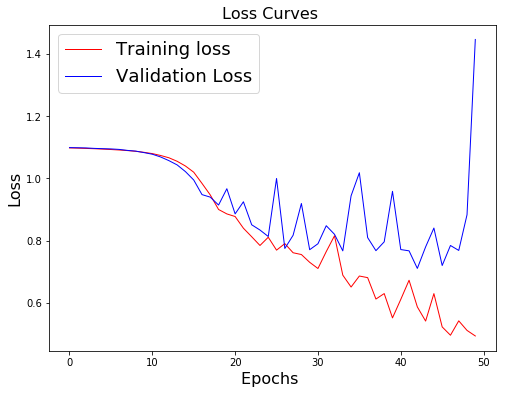

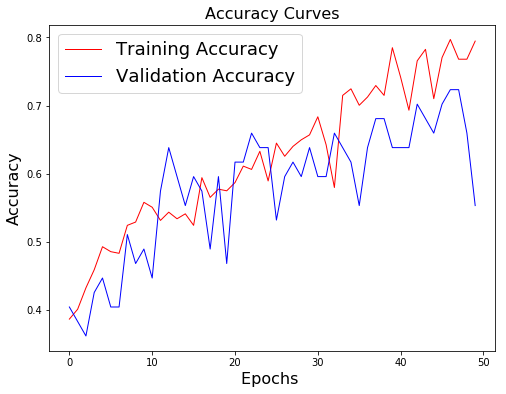

In [15]:
import matplotlib.pyplot as plt

[test_loss, test_acc] = VGG16Seq.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=1.0)
plt.plot(history.history['val_loss'],'b',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves ',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=1.0)
plt.plot(history.history['val_acc'],'b',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [16]:
import p5_util
filename = './data/vgg16_cnn.dump'
p5_util.object_dump(VGG16Seq,filename)